In [4]:
sys.path.insert(0,os.path.join(os.getcwd(),"../code/utils"))

%load_ext autoreload
%autoreload 2

In [37]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

import experiment_utils as utils
from experiment_utils import PATH_ROOT, PATH_DATA 

# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)


random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(0)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Boilerplate

In [6]:
# Set and test path to competition data files
try:
  if PATH_ROOT == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{PATH_ROOT}/{PATH_DATA}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


In [7]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = utils.load_data(experiment_auxiliary, PATH_ROOT + PATH_DATA)

In [8]:
train_aux = utils.aux_split(experiment_auxiliary_df)

In [9]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [10]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = utils.load_data(train_path, PATH_ROOT + PATH_DATA)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = utils.data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y, _ = utils.split_train_val(train_df)

val_y =  val_y.astype(int)
train_y =train_y.astype(int)
train_x = train_x.reshape(list(train_x.shape)+[1])
val_x = val_x.reshape(list(val_x.shape)+[1])

## Implementation

In [11]:
class DS(Dataset):
    def __init__(self,df,labels):
        super().__init__()
        self.df=df
        self.labels=labels
 
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        data = self.df[idx]
        label = self.labels[idx]        
        return data,label

In [79]:

'''
# Building the model
def create_model(input_shape, init):
  """
  CNN model.

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model    
  """
  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer = init, bias_regularizer='l2'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  model.add(Dense(1, activation='sigmoid', kernel_initializer = init))
  return model
'''

class base_base_model(nn.Module):
    '''
    Architecture built identical to base cnn model given to us.

    After some googling - it seems that for:
        [x] - kernel_initializer - as its set to init its the same as the default
        [ ] - bias_regularizer - that it set in the optimizer
    '''
    def __init__(self):
        super(base_base_model, self).__init__()
        self.cn1 = nn.Conv2d(1,16,3)
        self.cn2 = nn.Conv2d(16,32,3)
        self.fc1 = nn.Linear(5760,128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32,1)

        self.maxpool = nn.MaxPool2d((2,2))

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.permute(0,3,1,2)
        x = self.maxpool(F.relu(self.cn1(x)))
        x = self.maxpool(F.relu(self.cn2(x)))
        x = torch.flatten(x).reshape(batch_size,-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.sigmoid(self.fc3(x))


In [175]:
def pretty_log(log):
    for key,value in log.items():
        print("{} : {:.4f}".format(key,value))
    print("\n---------------------------\n")

def thresh(output, thresh_hold = 0.5):
    return [0 if x <thresh_hold else 1 for x in output]

In [176]:
def train_epochs(tr_loader,val_loader,model,criterion,optimizer, num_epochs):

    using_cuda = False

    if using_cuda:    
        if torch.has_cuda:
            device = torch.device('cuda:0')
        else:
            device = torch.device('cpu:0')
    else:
        device = torch.device('cpu:0')

    model.to(device)

    training_log =[]

    for epoch in range(num_epochs):

        print("started training epoch no. {}".format(epoch+1))

        tr_loss = 0
        tr_size = 0
        tr_y_hat = np.array([])

        for step,batch in enumerate(tr_loader):

            data, labels = batch
            data = data.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(data)

            loss = criterion(outputs,labels)
            loss.backward()
            
            tr_loss+=loss.item()
            tr_size+=data.shape[0]

            tr_y_hat = np.append(tr_y_hat,thresh(outputs.detach().numpy()))

            optimizer.step()
            optimizer.zero_grad()

        val_loss = 0
        val_size = 0
        val_y_hat = np.array([])

        for step, batch in enumerate(val_loader):
            
            data, labels = batch
            data = data.to(device,dtype=torch.float32)
            labels = labels.to(device,dtype=torch.float32)
            outputs = model(data)
            
            loss = criterion(outputs,labels)

            val_loss += loss.item()
            val_size += data.shape[0]

            val_y_hat = np.append(val_y_hat,thresh(outputs.detach().numpy()))


        tr_fpr, tr_tpr, _ = roc_curve(train_y, tr_y_hat)
        val_fpr, val_tpr, _ = roc_curve(val_y, val_y_hat)

        epoch_log = {'epoch': epoch,
                     'loss': tr_loss / tr_size,
                     'auc': auc(tr_fpr, tr_tpr),
                     'acc': accuracy_score(train_y,tr_y_hat),
                     'val_loss': val_loss / val_size,
                     'val_auc': auc(val_fpr,val_tpr),
                     'val_acc': accuracy_score(val_y,val_y_hat)}


        pretty_log(epoch_log)

        training_log.append(epoch_log)

    return training_log

In [177]:
train_set = DS(train_x,train_y)
val_set= DS(val_x,val_y)

train_loader=DataLoader(dataset= train_set, batch_size = 16, shuffle = True, num_workers = 2)
val_loader=DataLoader(dataset= val_set, batch_size = 16, shuffle = True, num_workers = 2)

In [178]:
model=base_base_model()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


#TODO: implement the Glorot Normal
# init = tf.keras.initializers.GlorotNormal(seed = 0)


In [179]:
train_epochs(train_loader,val_loader,model,criterion,optimizer,num_epochs= 10)

started training epoch no. 1
epoch : 0.0000
loss : 0.0136
auc : 0.5123
acc : 0.7672
val_loss : 0.0365
val_auc : 0.5280
val_acc : 0.5307

---------------------------

started training epoch no. 2
epoch : 1.0000
loss : 0.0103
auc : 0.4966
acc : 0.7463
val_loss : 0.0258
val_auc : 0.5201
val_acc : 0.5178

---------------------------

started training epoch no. 3
epoch : 2.0000
loss : 0.0084
auc : 0.5010
acc : 0.7480
val_loss : 0.0363
val_auc : 0.5096
val_acc : 0.5146

---------------------------

started training epoch no. 4
epoch : 3.0000
loss : 0.0066
auc : 0.5129
acc : 0.7537
val_loss : 0.0327
val_auc : 0.4484
val_acc : 0.4531

---------------------------

started training epoch no. 5
epoch : 4.0000
loss : 0.0048
auc : 0.4941
acc : 0.7450
val_loss : 0.0227
val_auc : 0.4967
val_acc : 0.4984

---------------------------

started training epoch no. 6
epoch : 5.0000
loss : 0.0040
auc : 0.4947
acc : 0.7453
val_loss : 0.0265
val_auc : 0.5169
val_acc : 0.5178

---------------------------

star

[{'epoch': 0,
  'loss': 0.013631657964157749,
  'auc': 0.5122888144882377,
  'acc': 0.767204628501827,
  'val_loss': 0.036547111172506336,
  'val_auc': 0.5279874213836478,
  'val_acc': 0.5307443365695793},
 {'epoch': 1,
  'loss': 0.01034379271289062,
  'auc': 0.49664313101512686,
  'acc': 0.7463459196102314,
  'val_loss': 0.02581090742909021,
  'val_auc': 0.520125786163522,
  'val_acc': 0.517799352750809},
 {'epoch': 2,
  'loss': 0.008360986304528962,
  'auc': 0.5010347951956332,
  'acc': 0.748020706455542,
  'val_loss': 0.036301715426074646,
  'val_auc': 0.509622641509434,
  'val_acc': 0.5145631067961165},
 {'epoch': 3,
  'loss': 0.006577164261301539,
  'auc': 0.512862472974516,
  'acc': 0.7536540803897686,
  'val_loss': 0.032671543434985635,
  'val_auc': 0.4483647798742138,
  'val_acc': 0.45307443365695793},
 {'epoch': 4,
  'loss': 0.004756201396154503,
  'auc': 0.4941346872778569,
  'acc': 0.7449756394640682,
  'val_loss': 0.022652488189800656,
  'val_auc': 0.49672955974842764,
  'v

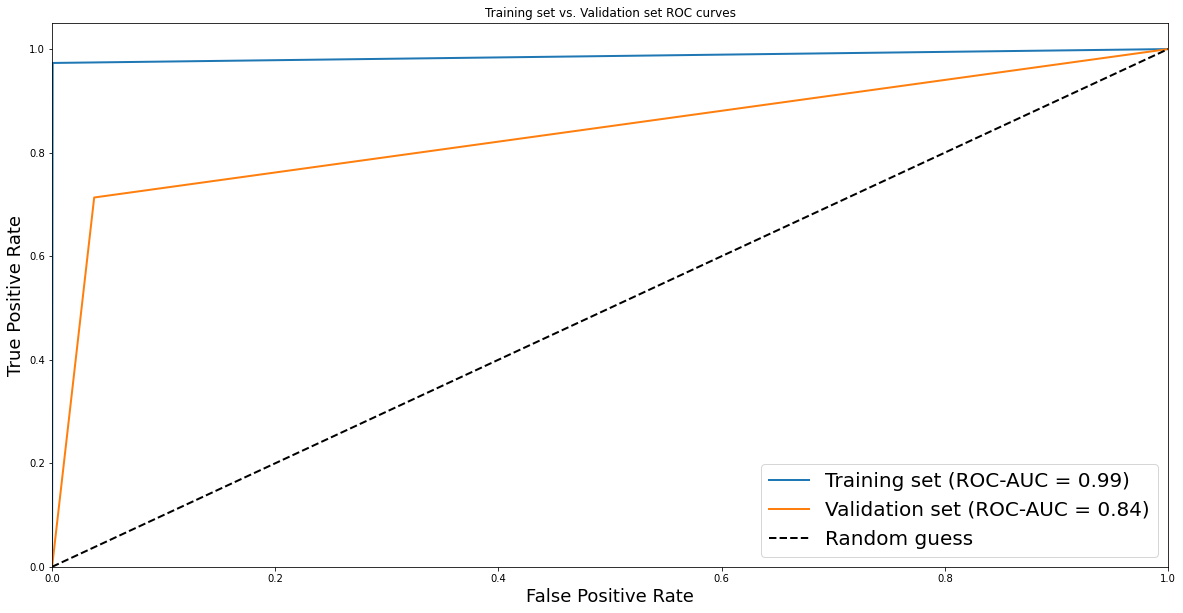

In [191]:
pred = [thresh(model(torch.from_numpy(train_x).type(torch.float32)).detach().cpu()),thresh(model(torch.from_numpy(val_x).type(torch.float32)).detach().cpu())]
actual = [train_y, val_y]
utils.stats(pred, actual)